# 프로젝트 : SRGAN 활용하기

목표 : 앞에서 사용했던 SRGAN 구조를 이용해 프로젝트를 수행해 봅시다.

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기
---
이제 여러분이 직접 다른 이미지를 사용해 볼 차례입니다.

앞서 사용했던 DIV2K 데이터셋은 bicubic interpolation을 이용해 가로 및 세로 픽셀 수를 1/4로 줄인 저해상도 이미지와 원래 고해상도 이미지 사이에서 학습되었습니다. 이 데이터셋으로 학습된 SRGAN를 이용해 좋은 결과를 얻기 위해서는 위와 같은 과정이 동일하게 진행되는 것이 좋습니다.

아래와 같이 두 가지 다른 단계를 거쳐서 직접 고른 이미지에 대해 SRGAN을 적용해 봅시다. (모델 학습을 진행하는 건 아닙니다❗) 테스트할 이미지를 고를 때, DIV2K 의 학습 데이터셋과 비슷한 종류의 이미지가 좋습니다. 일반적으로 자연, 동물, 건물 등의 이미지가 학습에 사용되었으며, 이와 달리 애니메이션 등의 이미지는 고해상도로 잘 변환되지 않을 수 있습니다.

특정 데이터셋에서만 학습되었기 때문에, 일반적으로 좋지 않은 결과가 나올 가능성이 높습니다. 결과와 상관없이 아래 과정만 잘 수행해봅시다.

## 프로젝트 1-1.
---

### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.  


(1708, 2560, 3)


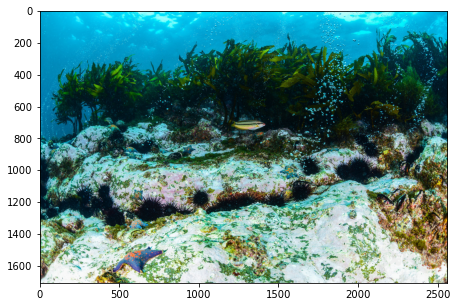

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

hr_image_path = os.getenv('HOME') +'/Project/ssacxaiffel/images/dokdo_3.jpg'
hr_image = cv2.imread(hr_image_path)
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(10,5))
plt.imshow(hr_image)

### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.  

In [2]:
image_width = hr_image.shape[1]//4
image_height = hr_image.shape[0]//4

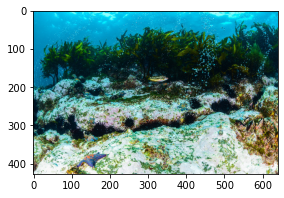

In [3]:
bicubic_image = cv2.resize(
    hr_image, 
    dsize=(image_width, image_height), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
plt.figure(figsize=(16,3))
plt.imshow(bicubic_image)

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [4]:
import tensorflow as tf
import os

model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
import numpy as np
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [6]:
srgan_hr = apply_srgan(bicubic_image)
print("✅")

✅


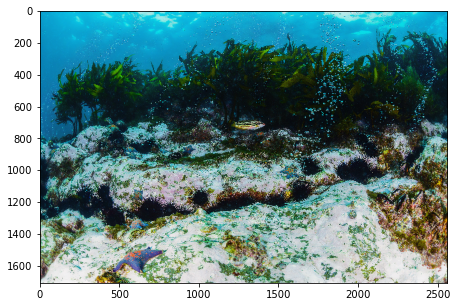

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(srgan_hr)

### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.


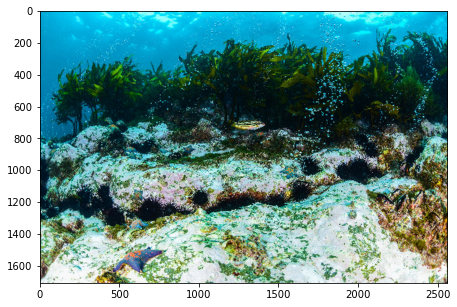

In [8]:
re_bicubic_image = cv2.resize(
    bicubic_image, 
    dsize=(image_width*4, image_height*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
plt.figure(figsize=(10,5))
plt.imshow(re_bicubic_image)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.


In [9]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

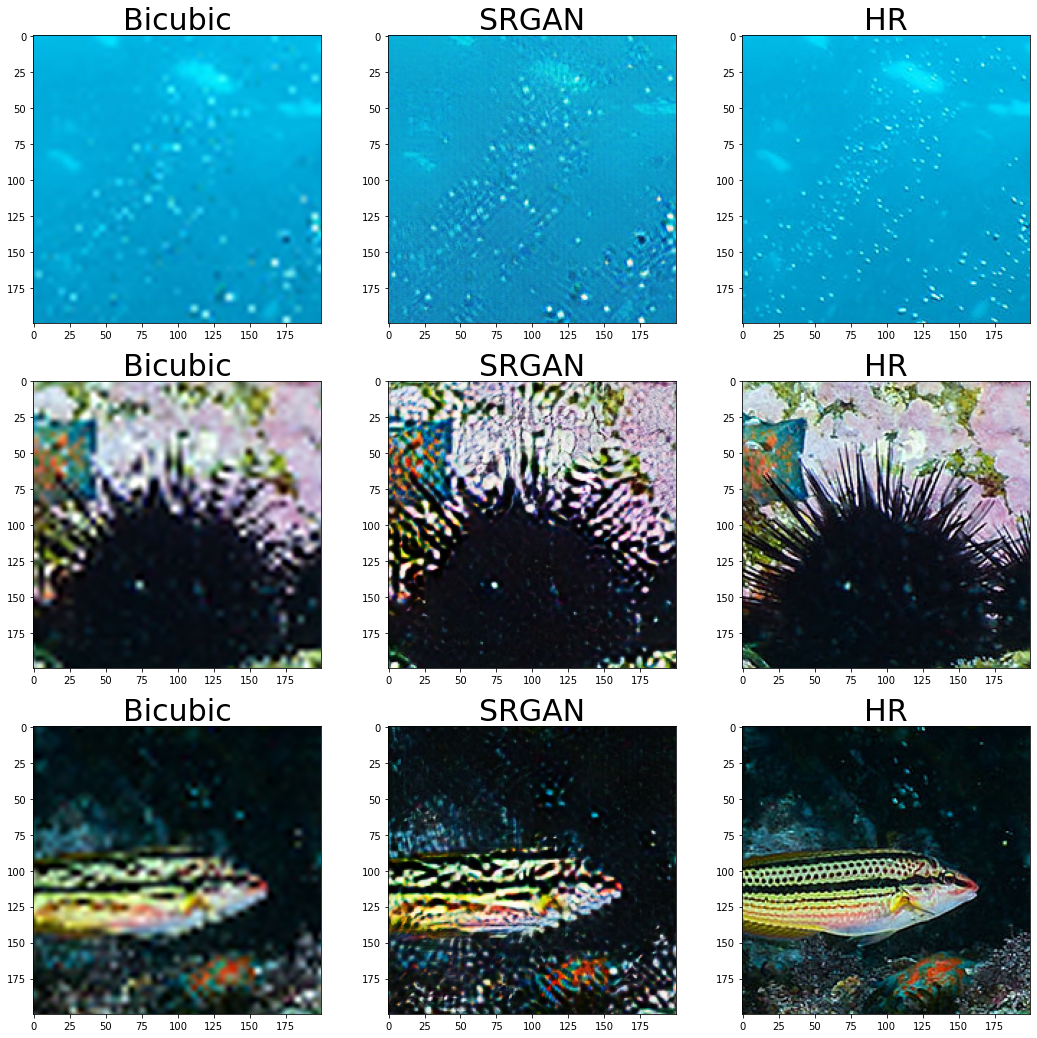

In [10]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(100,250), (1100,600), (600,1250)]

images = []
for left_top in left_tops:
    img1 = crop(re_bicubic_image, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)  



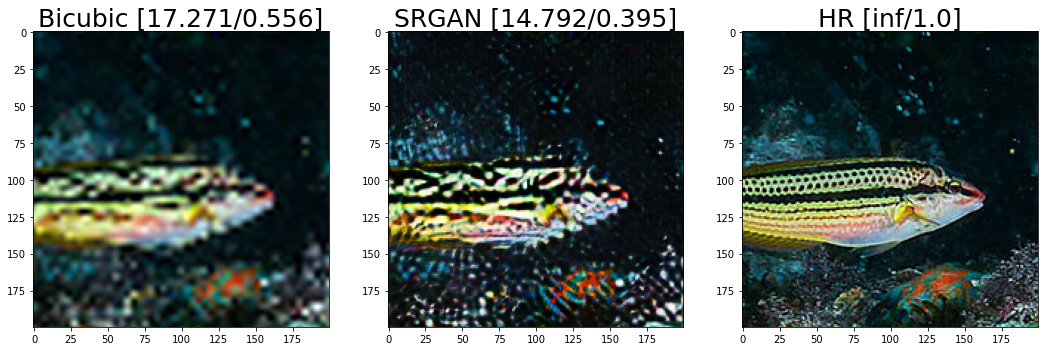

In [15]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

left_tops =  (600,1250)
images = []
img1 = crop(re_bicubic_image, left_top, 200, 200)
img2 = crop(srgan_hr , left_top, 200, 200)
img3 = crop(hr_image, left_top, 200, 200)
images.extend([img1, img2, img3])

psnr = [round(peak_signal_noise_ratio(images[-1], i), 3) for i in images]
ssim = [round(structural_similarity(images[-1], i, multichannel=True), 3) for i in images]

labels = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=25)    

PSNR과 SSIM 로 평가해보았습니다.   
-*PSNR(Peak Signal-to-Noise Ratio)은 영상 내 신호가 가질 수 있는 최대 신호에 대한 잡음(noise)의 비율*  
-*SSIM(Structural Similarity Index Map)은 영상의 구조 정보를 고려하여 얼마나 구조 정보를 변화시키지 않았는지를 계산*  

결과는 낮은 PSNR과 SSIM으로 나왔습니다. 눈으로 보기에도 고해상도 생성이 잘 되지 않은거 같습니다. 

하지만 SRGAN 결과의 경우 모양은 불분명하지만, 선명하게 표현되었습니다. 학습노드에서 설명했듯, Generator가 고해상도 이미지를 생성하는 과정에서 Discriminator를 속이기 위해 이미지를 진짜 같이 선명하게 만들도록 학습 되었기 때문입니다. VGG구조를 이용한 content loss를 통해 학습한 것 또한 사실적인 이미지를 형성하는데 크게 기여했다고 합니다. 다만, 입력되었던 저해상도 이미지가 매우 제한된 정보를 가지고 있기에 고해상도 이미지와 세부적으로 동일한 모양으로 선명하진 않은 것이라 합니다.

## 프로젝트 1-2.
---

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.


(500, 500, 3)


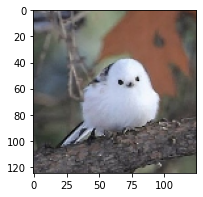

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

lr_image_path = os.getenv('HOME') +'/Project/ssacxaiffel/images/babsae.jpeg'
lr_image = cv2.imread(lr_image_path)
lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)

print(lr_image.shape)
lr_image_width = lr_image.shape[0]//4
lr_image_height = lr_image.shape[1]//4

bicubic_bird_image = cv2.resize(
    lr_image, 
    dsize=(lr_image_width, lr_image_height), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

plt.figure(figsize=(16,3))
plt.imshow(bicubic_bird_image)

### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.


In [10]:
srgan_bird = apply_srgan(bicubic_bird_image)
print("✅")

✅


### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.


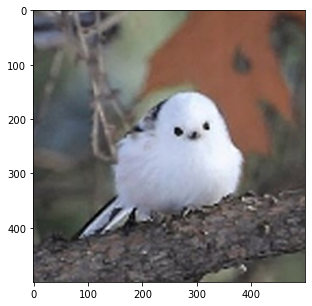

In [11]:
bicubic_image = cv2.resize(
    bicubic_bird_image, 
    dsize=(lr_image_width*4, lr_image_height*4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)
plt.figure(figsize=(10,5))
plt.imshow(bicubic_image)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

Text(0.5, 1.0, 'SRGAN')

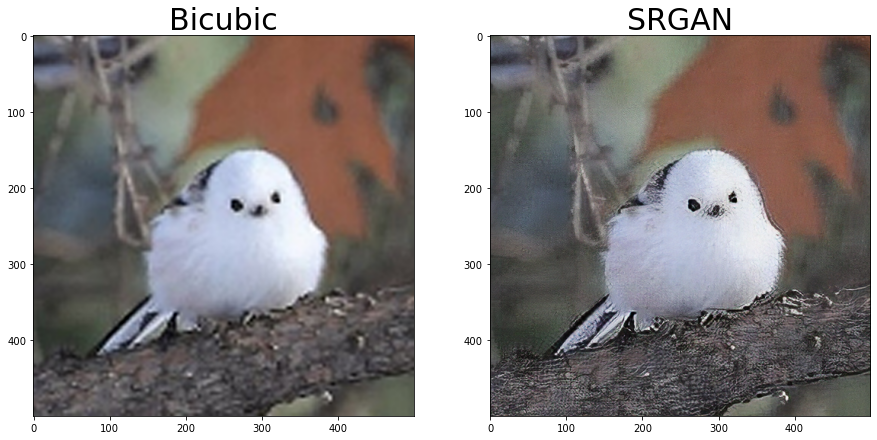

In [12]:
# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,2,1); plt.imshow(bicubic_image); plt.title("Bicubic", fontsize=30)
plt.subplot(1,2,2); plt.imshow(srgan_bird); plt.title("SRGAN", fontsize=30)

### 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)  



출력에 대해 정성적으로 설명해보려 합니다.   
DIV2K 데이터셋이 동물과 자연물의 학습데이터가 많다고 했습니다. 그래서인지 새의 털이나 나무의 결은 선명하게 자세히 표현된거 같습니다.
새의 털은 마치 고양이 털같이 길이가 어느정도 있는 것처럼 표현이 되었고, 나무는 나무딱지의 결이 나름 표현된거 같습니다. 
하지만 뒷 배경의 Blur 된 부분은 Super Resolution이 잘 되지 않았습니다. 형태를 잘 알 수 없는 배경이라 정확하게 표현을 못 한걸로 보입니다.
학습데이터가 무엇이냐에 따라 결과물이 다르게 나올거 같습니다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

이전 Super Resolution의 활용 사례에 대해 살펴봤을 때, 단일 이미지가 아닌 영상에 대해 Super Resolution을 적용한 사례가 있었습니다. 이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행해 봅시다.  

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환 시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.  

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.  
`$ pip install imageio`

### 1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

GIF files https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. frames이란 리스트 안에 각각의 프레임이 들어 있습니다.

In [55]:
import cv2

# 다운받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME') +'/Project/ssacxaiffel/images/gif/city_night_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


저해상도 Frame들을 확인해 봄

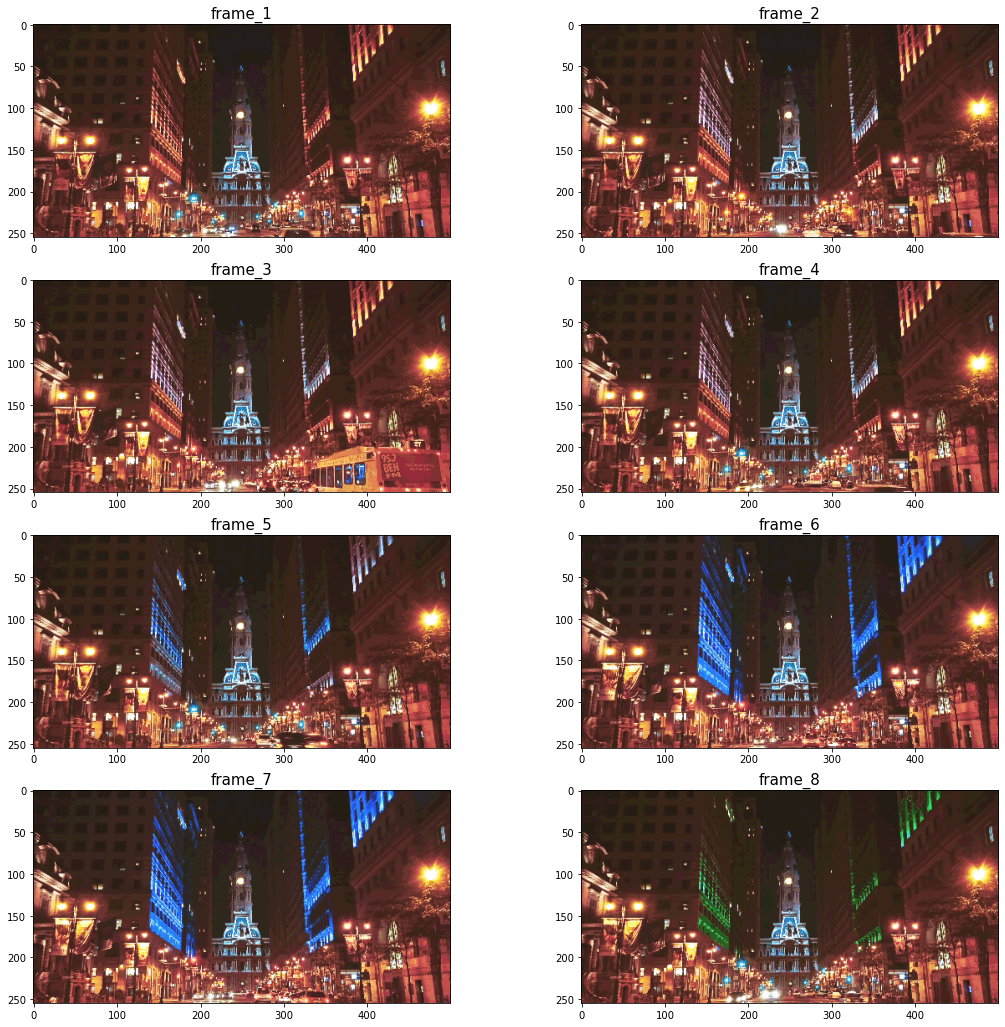

In [56]:
# Frame 각각을 출력
plt.figure(figsize=(18,18))
for i in range(len(frames)):
    plt.subplot(4,2,i+1) 
    plt.imshow(frames[i])
    plt.title(f'frame_{i+1}', fontsize=15)

### 2. 프레임별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.  

In [57]:
frames_sr_bicubic = []
frames_sr_srgan = []
for i in range(len(frames)):
    bicubic_frame = cv2.resize(
        frames[i], 
        dsize=(frames[i].shape[1]*4, frames[i].shape[0]*4), # (가로 픽셀 수, 세로 픽셀 수)
        interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
    )   
    # Bicubic interpolation
    frames_sr_bicubic.append(bicubic_frame)
    # SRGAN
    frames_sr_srgan.append(apply_srgan(frames[i]))

SRGAN으로 Super Resolution된 Frame들을 시각화 해 봄

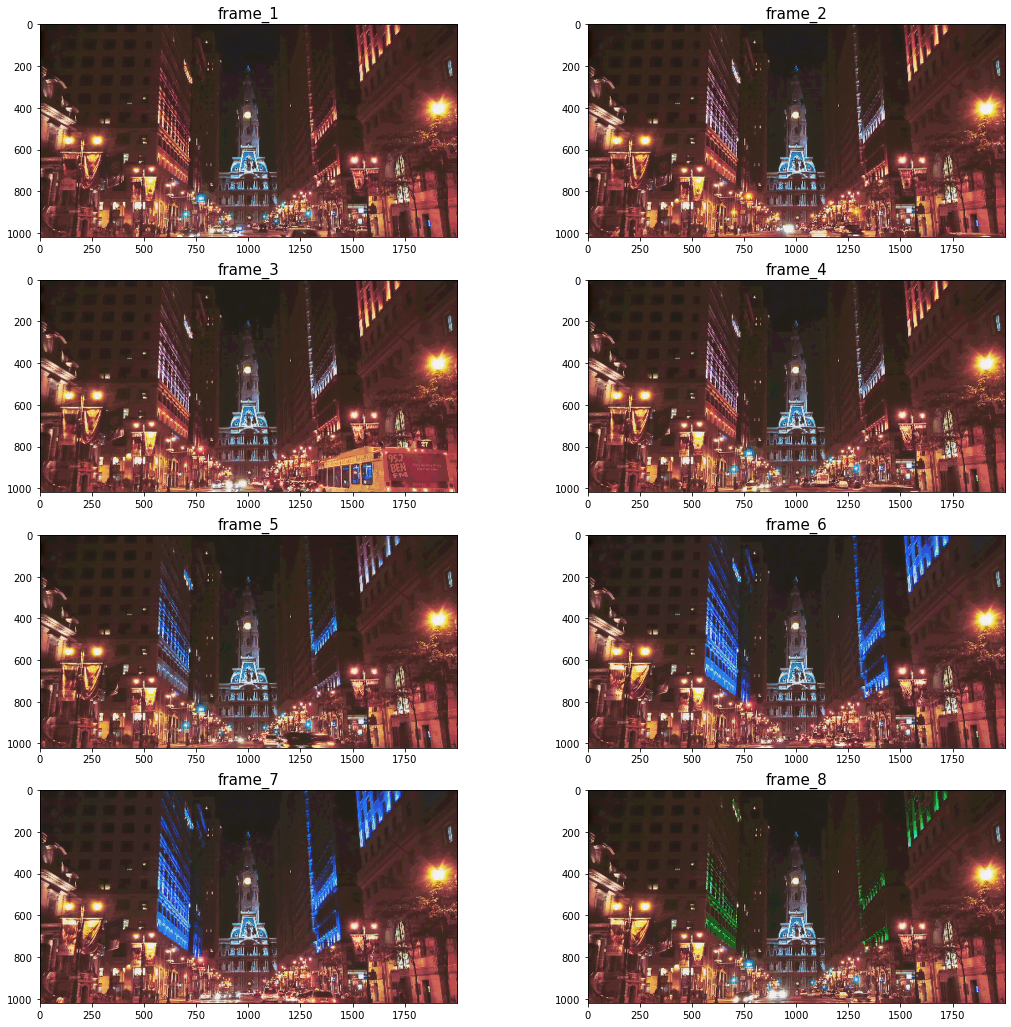

In [62]:
# SRGAN을 시각화 해봄 
plt.figure(figsize=(18,18))
for i in range(len(frames_sr_srgan)):
    plt.subplot(4,2,i+1) 
    plt.imshow(frames_sr_srgan[i])
    plt.title(f'frame_{i+1}', fontsize=15)

특정부분을 잘라내어서 Super Resolution이 어떻게 진행되었는지 확인

Text(0.5, 1.0, 'SRGAN')

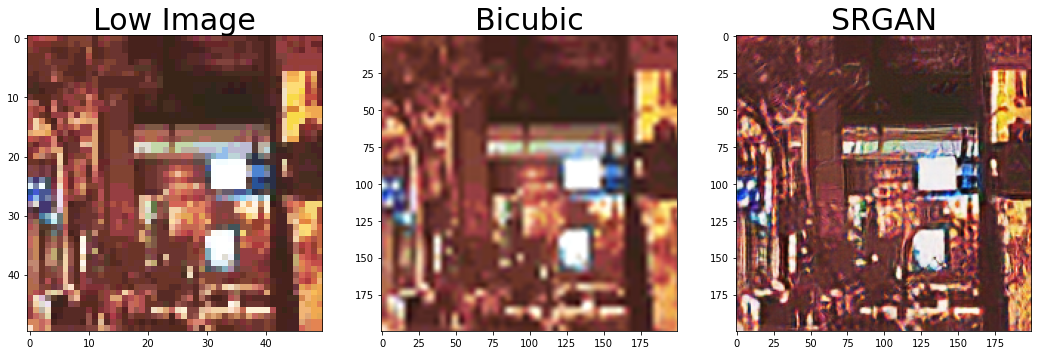

In [61]:
images = []
img1 = crop(frames[0], (200,350), 50, 50)
img2 = crop(frames_sr_bicubic[0] , (200*4, 350*4), 200, 200)
img3 = crop(frames_sr_srgan[0], (200*4, 350*4), 200, 200)
images.extend([img1, img2, img3])

labels = ["Low Image", "SRGAN", "Bicubic"] * 3

plt.figure(figsize=(18,18))
plt.subplot(1,3,1); plt.imshow(img1); plt.title("Low Image", fontsize=30)
plt.subplot(1,3,2); plt.imshow(img2); plt.title("Bicubic", fontsize=30)    
plt.subplot(1,3,3); plt.imshow(img3); plt.title("SRGAN", fontsize=30)   

### 3. 프레임을 합쳐 gif 만들기  
위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.  

In [63]:
import imageio

imageio.mimsave("./images/gif/Bicubic_고해상도.gif", frames_sr_bicubic)
print("✅")

✅


In [64]:
import imageio

imageio.mimsave("./images/gif/SRGAN_고해상도.gif", frames_sr_srgan)
print("✅")

✅


### 4. Jupyter notebook에 gif 표시하기  
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.  

- 저해상도

<img src="./images/gif/city_night_lr.gif" width="800" align="left"></imag>

- Bicubic

<img src="./images/gif/Bicubic_고해상도.gif" width="800" align="left"></imag>

- SRGAN

<img src="./images/gif/SRGAN_고해상도.gif" width="800" align="left"></imag>

## 느낀점
Super Resolution을 배울 수 있는 시간이였다.   
드라마나 영화가 리마스터링 된다고 해서 어떻게 하는 것일까 궁금했었는데, 이번 시간에 배울 수 있었다.    
학습된 SRGAN 모델로 프로젝트를 진행했다.    
학습된 모델이 어떤 데이터로 학습되었느냐에 따라 성능이 달라질 수 있다는 것을 또 한 번 깨달았다.    
시간당 9,000원 어노테이션 알바를 한 적이 있는데, 그 일이 AI 발전에 얼마나 중요한 일인가를 새삼 느꼈다.   
노드 치기도 힘든데, 그냥 알바나 할까 싶다...  
주어진 학습 모델이 아닌 내가 직접 성능 좋은 모델을 만들 수 있는 날이 왔으면 좋겠다.   